[View in Colaboratory](https://colab.research.google.com/github/Larissa13/Mac6914/blob/master/5_3_Using_a_pre_trained_convnet.ipynb)

In [30]:
import keras
keras.__version__

'2.1.6'

**Importanto a VGG16**

In [0]:
from keras.applications import VGG16

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Importando os dados necessários**

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [0]:
base_dir = base_dir = 'cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

**Extração de Features**

In [0]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
              directory,
              target_size=(150, 150),
              batch_size=batch_size,
              class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i=i+1
    if i*batch_size>sample_count:
      break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

FileNotFoundError: ignored

**Flatten features para usar num classificador densamente conectado**

In [0]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

**Classificador densamente conectado**

In [0]:
from keras import models, layers, optimizers

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(train_features, train_labels, epochs=30 , batch_size=20 , validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6948 - acc: 0.9920 - val_loss: 0.6886 - val_acc: 0.9910
Epoch 2/30
2000/2000 [==============================] - 1s 716us/step - loss: 0.6858 - acc: 0.9955 - val_loss: 0.6793 - val_acc: 0.9940
Epoch 3/30
2000/2000 [==============================] - 1s 694us/step - loss: 0.6780 - acc: 0.9960 - val_loss: 0.6719 - val_acc: 0.9930
Epoch 4/30
2000/2000 [==============================] - 1s 688us/step - loss: 0.6699 - acc: 0.9965 - val_loss: 0.6641 - val_acc: 0.9940
Epoch 5/30
2000/2000 [==============================] - 1s 686us/step - loss: 0.6620 - acc: 0.9970 - val_loss: 0.6564 - val_acc: 0.9940
Epoch 6/30
2000/2000 [==============================] - 1s 658us/step - loss: 0.6537 - acc: 0.9955 - val_loss: 0.6485 - val_acc: 0.9940
Epoch 7/30
2000/2000 [==============================] - 1s 658us/step - loss: 0.6422 - acc: 0.9995 - val_loss: 0.6400 - val_acc: 0.9940
Ep

**Mostrando o desempenho da rede no conjunto de treinamento e no de validação**

In [0]:
import matplotlib.pyplot as plt

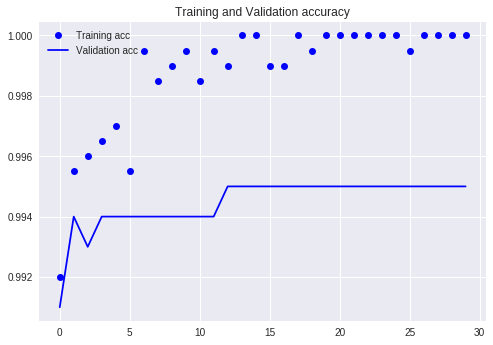

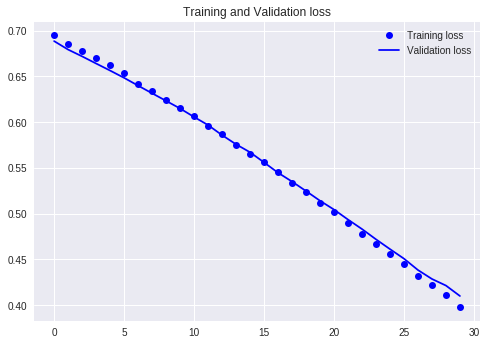

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.legend()

plt.show()

**Contrução de modelo VGG16 + Densely Connected Classifier**

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


**Congelando as camadas da VGG16**

In [18]:
print("Número de parâmetros treináveis antes de congelar a conv_base: " , len(model.trainable_weights))

Número de parâmetros treináveis antes de congelar a conv_base:  30


In [0]:
conv_base.trainable=False

In [20]:
print("Número de parâmetros treináveis após congelar a conv_base:", len(model.trainable_weights))

Número de parâmetros treináveis após congelar a conv_base: 4


**Data augmentation**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'binary_crossentropy', metrics = ['acc'])

history = model.fit_generator(train_generator, steps_per_epoch = 100, 
                              epochs = 30, validation_data=validation_generator, 
                              validation_steps=50, verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 46s - loss: 0.6022 - acc: 0.6860 - val_loss: 0.4666 - val_acc: 0.8070
Epoch 2/30
 - 42s - loss: 0.4931 - acc: 0.7825 - val_loss: 0.3870 - val_acc: 0.8510
Epoch 3/30
 - 41s - loss: 0.4389 - acc: 0.8095 - val_loss: 0.3477 - val_acc: 0.8640
Epoch 4/30
 - 42s - loss: 0.4074 - acc: 0.8200 - val_loss: 0.3203 - val_acc: 0.8730
Epoch 5/30
 - 43s - loss: 0.3939 - acc: 0.8275 - val_loss: 0.3164 - val_acc: 0.8700
Epoch 6/30
 - 42s - loss: 0.3687 - acc: 0.8345 - val_loss: 0.2931 - val_acc: 0.8790
Epoch 7/30
 - 43s - loss: 0.3688 - acc: 0.8370 - val_loss: 0.2889 - val_acc: 0.8840
Epoch 8/30
 - 43s - loss: 0.3413 - acc: 0.8510 - val_loss: 0.2896 - val_acc: 0.8700
Epoch 9/30
 - 41s - loss: 0.3450 - acc: 0.8535 - val_loss: 0.2677 - val_acc: 0.8990
Epoch 10/30
 - 43s - loss: 0.3334 - acc: 0.8580 - val_loss: 0.2665 - val_acc: 0.8900
Epoch 11/30
 - 42s - loss: 0.3386 - acc: 0.8485 - val_loss: 0.2642 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

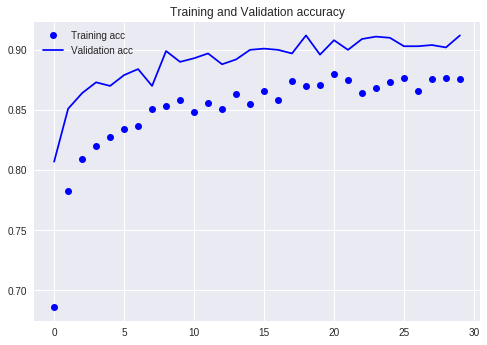

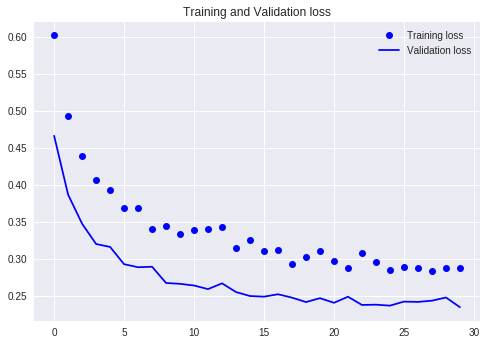

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.legend()

plt.show()

**Fine Tuning**

In [27]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
conv_base.trainable = True 

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable= True
  if set_trainable:
    layer.trainable = True
  else: 
    layer.trainable = False


In [29]:
model.compile(optimizer = optimizers.RMSprop(lr = 1e-5), loss = "binary_crossentropy", metrics = ['acc'])

history  = model.fit_generator(train_generator, steps_per_epoch = 100, epochs = 100,
                               validation_data = validation_generator, validation_steps=50)


Epoch 1/100
100/100 [==============================] - 50s 499ms/step - loss: 0.2991 - acc: 0.8705 - val_loss: 0.2509 - val_acc: 0.8950
Epoch 2/100
100/100 [==============================] - 44s 438ms/step - loss: 0.2627 - acc: 0.8890 - val_loss: 0.2079 - val_acc: 0.9170
Epoch 3/100
100/100 [==============================] - 46s 456ms/step - loss: 0.2401 - acc: 0.8945 - val_loss: 0.1995 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 45s 450ms/step - loss: 0.2133 - acc: 0.9095 - val_loss: 0.2145 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 43s 425ms/step - loss: 0.2165 - acc: 0.9085 - val_loss: 0.1829 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 44s 441ms/step - loss: 0.1906 - acc: 0.9210 - val_loss: 0.1861 - val_acc: 0.9320
Epoch 7/100
100/100 [==============================] - 44s 438ms/step - loss: 0.1818 - acc: 0.9250 - val_loss: 0.1890 - val_acc: 0.9340
Epoch 8/100
100/100 [===========================

KeyboardInterrupt: ignored

In [0]:
model.save('cats_and_dogs_small_4.h5')

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)